# What data did we use?

Samples: the PDF on a grid (rmin = 1.5, rmax = 30.0, rstep = $pi$ / 23.0). It is a 1D vector of shape `(209,)`.

The PDFs are simulated from 10,000 combination of the structures randomly choosen from about 2000 structures. For each combination, the simulation is done usng 11 different mole fractions `[[1.0, 0.0], [0.0, 1.0], [0.95, 0.05], [0.05, 0.95], [0.2, 0.8], [0.8, 0.2], [0.3, 0.7], [0.7, 0.3], [0.4, 0.6], [0.6, 0.4], [0.5, 0.5]]`. In total, there are 110,000 PDFs.

Labels: the mole fraction of the major phase and the minor phase. For example, `[0.8, 0.2]` means the the major phase is 80 % and the minor phase is 20 % in mole fraction.

Datasets: 80% train, 10% validation, 10% test. The data set is shuffled when splitting and the train data set is shuffled in every training epoch.

# What models did we use?

We tested three models:

1. Logistric regression (LR)

1. Convolutional neural network (CNN)

2. Convolutional neural network + Full connected layers (CNN-FC)

Please look at section 06, 07, 08 for the details.

# How do we optimize the model

Loss: mean squared error

Metric: cosine similarity

# How good is our model?

In [19]:
# choose the tensorflow log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import tensorflow as tf

## Scalar metrics

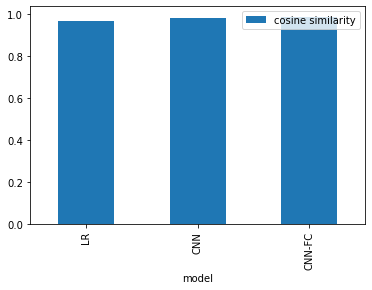

In [12]:
df = pd.DataFrame(
    {"cosine similarity": [0.9668, 0.9830, 0.9887]},
    index=pd.Index(["LR", "CNN", "CNN-FC"], name="model")
)
df.plot.bar();

## Predict some random batch

In [82]:
FEATURES_FILE = "./data/tensors/features_continous.npy"  # path to the file of the feature tensor
LABELS_FILE = "./data/tensors/labels_continous.npy"  # path to the file of the feature tensor
BATCH_SIZE = 4096  # number of points to test
LR_MODEL_FILE = "./data/models/lr_20210914-153328/"
CNN_MODEL_FILE = "./data/models/cnn_1_20210914-125805/"
CNNFC_MODEL_FILE = "./data/models/cnn_2_20210914-150241/"

In [83]:
def load_data():
    # load
    features, labels = np.load(FEATURES_FILE), np.load(LABELS_FILE)
    # sort the labels
    labels = np.sort(labels, axis=1)[:, ::-1]
    # shuffle
    n = features.shape[0]
    shuffled_idx = np.random.permutation(n)
    features, labels = features[shuffled_idx], labels[shuffled_idx]
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(BATCH_SIZE)

In [84]:
data = load_data()

In [85]:
def evulate_model(model, samples, labels):
    pred = model.predict_on_batch(samples)
    ds = xr.Dataset(
        {
            "prediction": (["sample", "phase"], pred),
            "expection": (["sample", "phase"], labels)
        }, 
        coords={"phase": ["major", "minor"]}
    )
    return ds

def evaludate_models(models, model_names, samples, labels):
    dss = []
    n = len(models)
    for i in range(n):
        ds = evulate_model(models[i], samples, labels)
        ds = ds.assign_coords({"model": model_names[i]}).expand_dims("model")
        dss.append(ds)
    return xr.merge(dss)

In [93]:
gen = data.as_numpy_iterator()

In [94]:
test_samples, test_labels = next(gen)

In [87]:
lr_model = tf.keras.models.load_model(LR_MODEL_FILE)
ncc_model = tf.keras.models.load_model(CNN_MODEL_FILE)
nccfc_model = tf.keras.models.load_model(CNNFC_MODEL_FILE)

In [110]:
eval_res = evaludate_models(
    [lr_model, ncc_model, nccfc_model],
    ["1_LR", "2_CNN", "3_CNNFC"],
    test_samples,
    test_labels
)

In [117]:
def visualize(eval_res):
    facet = eval_res.plot.scatter(x="prediction", y="expection", col="model", hue="phase", sharex=False, sharey=False, size=4)
    for ax in facet.axes.flatten():
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_aspect("equal")
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', alpha=0.5, color="black")
    return facet

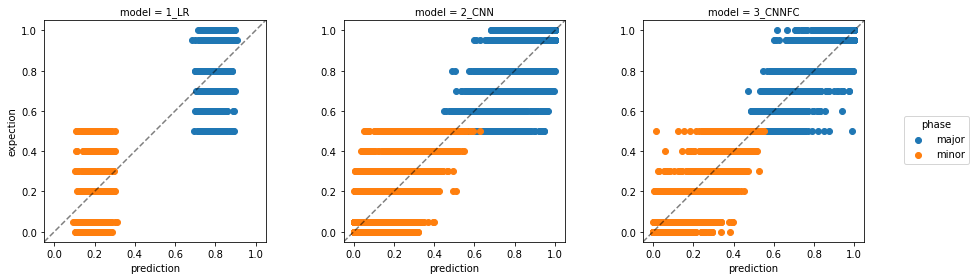

In [118]:
visualize(eval_res);

# Conlcusion

It looks that the models cannot get the idea of the mole fraction very well. Maybe it is better to change back to the single/multiphase label.